# Project: ICD-AIS conversion using Deep Learning utilizing ICD10

This script analyzes the results of the translations using different methods.

## Setup

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics
import seaborn as sb
import matplotlib.pyplot as plt

#### Files

In [2]:
# results
results_file = "../Results/ais_results.csv"

# test demographic file
test_demo_file = "../Data/NTDB_combine/ntdb_test_demo.csv"

### Load data

In [3]:
# Load result files
res = pd.read_csv(results_file)

# load demographics
demo = pd.read_csv(test_demo_file)

## Functions for analysis

In [4]:
def calc_diff(p1, n1, p2, n2):
    '''
    This function calculates a difference between to proportions and 
    the 95% CI.
    
    Parameters:
    p1 - first proportion
    n1 - number of samples in population 1
    p2 - first proportion
    n2 - number of samples in population 2
    
    Returns 
    difference, lower limit of 95%CI, upper limit of 95%CI
    '''
    
    # absolute difference
    diff = p2-p1
    
    # standard error for each proportion
    se1 = np.sqrt(p1*(1-p1)/n1)  
    se2 = np.sqrt(p2*(1-p2)/n2)  
    
    # standard errof for difference
    se = np.sqrt(se1**2 + se2**2)
    
    # get upper and lower limits for diff
    ll = diff - 1.96*se
    ul = diff + 1.96*se
    
    return diff, ll, ul

In [5]:
def calc_ci(p, n):
    '''
    This function calculates a 95% CI for a proportion 
    based on the number of samples.
    
    Parameters:
    p - proportion
    n - number of samples
    
    Returns:
    proportion, lower limit of 95%CI, upper limit of 95%CI
    '''
    
    
    # standard error 
    se = np.sqrt(p*(1-p)/n)  
    
    # get upper and lower limits for diff
    ll = p - 1.96*se
    ul = p + 1.96*se
    
    return p, ll, ul

In [6]:
def sens_spec(TP, TN, FP, FN):
    '''
    This function calculates sensitivity and specificity from
    true positives, true negatives, false positives, and false negatives.
    
    Parameters:
    TP - true positives
    TN - true negatives
    FP - false positives
    FN - false negatives
    
    Returns:
    sensitivity, specificity
    '''
    
    sens = TP/(TP+FN)
    spec = TN/(TN+FP)
    
    return sens, spec

In [7]:
def sens_spec_df(df, obs, pred):
    '''
    This function calculates sensitivity and specificity from
    a dataframe.
    
    Parameters:
    df - dataframe with data
    obs - column with observe outcomes (binary outcome)
    pred - column with predictions (binary outcome)
    
    Returns:
    sensitivity, specificity
    '''    
    tp = sum(np.where((res[obs]==1) & (res[pred]==1),1,0))
    tn = sum(np.where((res[obs]==0) & (res[pred]==0),1,0))
    fp = sum(np.where((res[obs]==0) & (res[pred]==1),1,0))
    fn = sum(np.where((res[obs]==1) & (res[pred]==0),1,0))

    return sens_spec(tp, tn, fp, fn)

In [8]:
def f1(df, obs, pred):
    '''
    This function calculates F1 score from a dataframe.
    
    Parameters:
    df - dataframe with data
    obs - column with observe outcomes (binary outcome)
    pred - column with predictions (binary outcome)
    
    Returns:
    F1 score
    '''    
    
    tp = sum(np.where((res[obs]==1) & (res[pred]==1),1,0))
    fp = sum(np.where((res[obs]==0) & (res[pred]==1),1,0))
    fn = sum(np.where((res[obs]==1) & (res[pred]==0),1,0))

    return (2*tp)/(2*tp+fp+fn)

In [9]:
def auc(df, obs, pred):
    '''
    This function calculates area under the receiver operator 
    characteristic curve (AUC) from a dataframe.
    
    Parameters:
    df - dataframe with data
    obs - column with observe outcomes (binary outcome)
    pred - column with predictions (continuous/discrete outcome)
    
    Returns:
    AUC
    '''       
    
    # sort values and drop NAs
    df = df[[obs,pred]].dropna().sort_values(pred)

    # get false positive rate, true positive rate, and threshold
    fpr, tpr, thresholds = metrics.roc_curve(df[obs], df[pred], pos_label=1)
    
    # return the AUC based on the fpr, tpr
    return metrics.auc(fpr, tpr)

In [127]:
def heatmap_df(df, obs, pred, max_iss, xtitle, ytitle, fontsize=15):
    '''
    This function draws a heatmap for the correlation between
    observed and predicted ISS values
    
    Parameters:
    df - dataframe with data
    obs - column with observe outcomes (continuous/discrete outcome)
    pred - column with predictions (continuous/discrete outcome)
    max_iss - maximum ISS for plot
    xtitle - x-axis label
    ytitle - y-axis label
    fontsize - size of axis labels font
    
    Returns:
    pointer to plot
    '''      
    
    # create a list of integers
    X = range(1,max_iss+1)
    Y = range(1,max_iss+1)

    # create empty list for data
    data = np.zeros((max_iss, max_iss))

    # loop through observed ISS values
    for x in X:
        # get predictions for obs value of ISS
        pred_iss = df[df[obs]==x][pred]

        # determine number of prediction for obs value of ISS
        num_iss = len(pred_iss)

        # loop through predicted ISS
        for y in Y:
            # determine number of predictions for specific ISS
            num_pred = len(pred_iss[pred_iss==y])

            # if number of predictions is not zero
            if num_iss!=0:
                
                # determine ratio of predictions at this value to 
                #  total number of predictions for observed ISS
                data[y-1,x-1] = num_pred/num_iss

    # convert to dataframe
    df = pd.DataFrame(data, index=Y, columns=X)

   
    # draw heat map
    ax = sb.heatmap(df, cmap=sb.color_palette("gray_r",75))
    
    # adjust labels and tick marks
    ax.invert_yaxis()
    ax.set_xticks([1,16,max_iss])
    ax.set_xticklabels([1,16,max_iss])
    ax.set_yticks([1,16,max_iss])
    ax.set_yticklabels([1,16,max_iss])
    plt.xlabel(xtitle, fontsize=fontsize)
    plt.ylabel(ytitle, fontsize=fontsize)
    
    return ax

In [11]:
def rmse(df, obs, pred):
    '''
    This function calculates root mean squared error 
    from a dataframe.
    
    Parameters:
    df - dataframe with data
    obs - column with observe outcomes (continuous/discrete outcome)
    pred - column with predictions (continuous/discrete outcome)
    
    Returns:
    RMSE
    '''    
    
    # make column for squared difference
    df['res_sq'] = (df[obs] - df[pred])**2
    
    # remove NAs
    df = df.dropna()
    
    # get sum of residual squared
    res_sq_sum = df.res_sq.sum()
    
    # divide by number of samples and take sq root
    rmse = np.sqrt(res_sq_sum/len(df))
    
    return rmse

In [12]:
def fpr_fnr(df, obs, pred):
    '''
    This function calculates sensitivity and specificity from
    a dataframe.
    
    Parameters:
    df - dataframe with data
    obs - column with observe outcomes (binary outcome)
    pred - column with predictions (binary outcome)
    
    Returns:
    false positive rate, false negative rate
    '''    
    tp = sum(np.where((res[obs]==1) & (res[pred]==1),1,0))
    tn = sum(np.where((res[obs]==0) & (res[pred]==0),1,0))
    fp = sum(np.where((res[obs]==0) & (res[pred]==1),1,0))
    fn = sum(np.where((res[obs]==1) & (res[pred]==0),1,0))

    return (fp/(fp+tn)), (fn/(fn+tp))

In [13]:
def under_est(df, obs, pred):
    '''
    This function calculates sensitivity and specificity from
    a dataframe.
    
    Parameters:
    df - dataframe with data
    obs - column with observe outcomes (binary outcome)
    pred - column with predictions (binary outcome)
    
    Returns:
    rate of underestimation when predictions were incorrect
    '''    
    fp = sum(np.where((res[obs]==0) & (res[pred]==1),1,0))
    fn = sum(np.where((res[obs]==1) & (res[pred]==0),1,0))

    return (fn/(fn+fp))

In [149]:
def wgt_kappa(y1, y2, weight):
    
    kappa = metrics.cohen_kappa_score(y1.fillna(0), 
                                      y2.fillna(0),
                                      weights=weight)
    return kappa

## Primary analysis (ISS>=16, MAIS >=3, MAIS >=2)

### Calculate CI for accuracy ISS >=16

In [30]:
acc_nmt = calc_ci(res.iss16_correct_nmt.mean(), 10_000)
acc_nmt

(0.9368, 0.9320308821820382, 0.9415691178179617)

In [31]:
acc_map = calc_ci(res.iss16_correct_aaam.mean(), 10_000)
acc_map

(0.9132, 0.9076817815953335, 0.9187182184046665)

In [32]:
acc_icdpic = calc_ci(res.iss16_correct_icdpic.mean(), 10_000)
acc_icdpic

(0.8732, 0.8666781236349038, 0.8797218763650961)

### Calc absolute difference and 95%CI

In [133]:
calc_diff(0.9132, 10_000, 0.9368, 10_000)

(0.023599999999999954, 0.01630649473002174, 0.03089350526997817)

In [134]:
calc_diff(0.8732, 10_000, 0.9368, 10_000)

(0.06359999999999999, 0.05552043589769843, 0.07167956410230156)

### Sensitivity and specificity for ISS>=16

In [38]:
sens_spec_df(res, 'iss16_obs', 'iss16_nmt')

(0.71280276816609, 0.9746347165400351)

In [39]:
sens_spec_df(res, 'iss16_obs', 'iss16_aaam')

(0.4795847750865052, 0.9864406779661017)

In [40]:
sens_spec_df(res, 'iss16_obs', 'iss16_icdpic')

(0.5550173010380622, 0.9269433080070134)

### Calculate AUC for ISS>=16

In [56]:
auc(res, 'iss16_obs', 'iss_nmt')

0.9426004744364497

In [57]:
auc(res, 'iss16_obs', 'iss_aaam')

0.9219341974077767

In [58]:
auc(res, 'iss16_obs', 'iss_icdpic')

0.8785687562060269

### Calculate CI for accuracy MAIS >=3

In [35]:
calc_ci(res.mais3_correct_nmt.mean(), 10_000)

(0.9126, 0.9070645616290667, 0.9181354383709333)

In [36]:
calc_ci(res.mais3_correct_aaam.mean(), 10_000)

(0.845, 0.8379066682017545, 0.8520933317982454)

In [37]:
calc_ci(res.mais3_correct_icdpic.mean(), 10_000)

(0.688, 0.6789191273018502, 0.6970808726981497)

### Sensitivity and specificity for MAIS>=3

In [44]:
sens_spec_df(res, 'mais3_obs', 'mais3_nmt')

(0.820995145631068, 0.9576372315035799)

In [45]:
sens_spec_df(res, 'mais3_obs', 'mais3_aaam')

(0.8413228155339806, 0.8468078758949881)

In [46]:
sens_spec_df(res, 'mais3_obs', 'mais3_icdpic')

(0.506371359223301, 0.7772971360381862)

### Calculate AUC for MAIS>=3

In [59]:
auc(res, 'mais3_obs', 'mais_nmt')

0.9213651880778322

In [60]:
auc(res, 'mais3_obs', 'mais_aaam')

0.8556871794045579

In [61]:
auc(res, 'mais3_obs', 'mais_icdpic')

0.7184124560833121

### Calculate CI for accuracy MAIS >=2

In [120]:
calc_ci(res.mais2_correct_nmt.mean(), 10_000)

(0.9564, 0.9523976128115337, 0.9604023871884664)

In [121]:
calc_ci(res.mais2_correct_aaam.mean(), 10_000)

(0.7481, 0.7395915591802963, 0.7566084408197037)

In [122]:
calc_ci(res.mais2_correct_icdpic.mean(), 10_000)

(0.7333, 0.7246322091847114, 0.7419677908152885)

### Sensitivity and specificity for MAIS>=2

In [112]:
sens_spec_df(res, 'mais2_obs', 'mais2_nmt')

(0.9603509912252194, 0.9500780031201248)

In [113]:
sens_spec_df(res, 'mais2_obs', 'mais2_aaam')

(0.9678258043548911, 0.3965158606344254)

In [114]:
sens_spec_df(res, 'mais2_obs', 'mais2_icdpic')

(0.7383815404614885, 0.7251690067602704)

### Calculate AUC for MAIS>=2

In [117]:
auc(res, 'mais2_obs', 'mais_nmt')

0.9562434057323295

In [118]:
auc(res, 'mais2_obs', 'mais_aaam')

0.8536490647146198

In [119]:
auc(res, 'mais2_obs', 'mais_icdpic')

0.760875376516523

## Exact accuracy for ISS

### Accuracy

In [14]:
calc_ci(res.iss_correct_nmt.mean(), 10_000)

(0.7779, 0.769753102798341, 0.7860468972016591)

In [15]:
calc_ci(res.iss_correct_aaam.mean(), 10_000)

(0.6894, 0.6803303101385769, 0.6984696898614231)

In [16]:
calc_ci(res.iss_correct_icdpic.mean(), 10_000)

(0.1772, 0.16971597772146554, 0.18468402227853445)

### Weight kappa

In [158]:
wgt_kappa(res.iss_obs, res.iss_nmt, 'quadratic')

0.881142395581045

In [160]:
wgt_kappa(res.iss_obs, res.iss_aaam, 'quadratic')

0.7736235564871178

In [159]:
wgt_kappa(res.iss_obs, res.iss_icdpic, 'quadratic')

0.632039842725689

### Calibration plot

<AxesSubplot:xlabel='Observed ISS', ylabel='Predicted ISS(NMT)'>

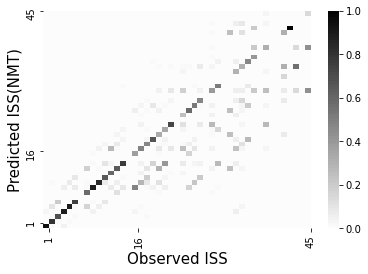

In [128]:
heatmap_df(res, 'iss_obs', 'iss_nmt', 45, 'Observed ISS', 'Predicted ISS(NMT)')

<AxesSubplot:xlabel='Observed ISS', ylabel='Predicted ISS(ICD-to-AIS Map)'>

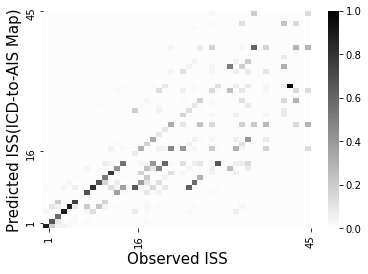

In [129]:
heatmap_df(res, 'iss_obs', 'iss_aaam', 45, 'Observed ISS', 'Predicted ISS(ICD-to-AIS Map)')

<AxesSubplot:xlabel='Observed ISS', ylabel='Predicted ISS(ICDPIC-R)'>

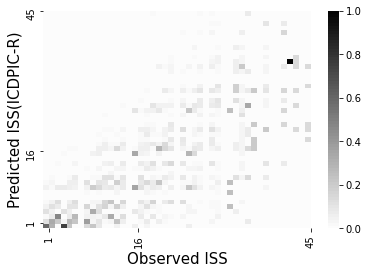

In [130]:
heatmap_df(res, 'iss_obs', 'iss_icdpic', 45, 'Observed ISS', 'Predicted ISS(ICDPIC-R)')

<AxesSubplot:xlabel='iss_obs', ylabel='iss_nmt'>

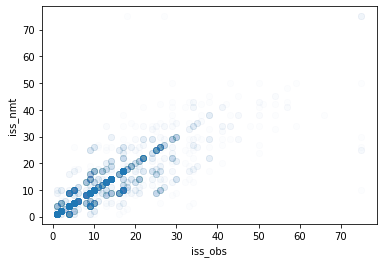

In [68]:
res.plot.scatter(x='iss_obs',y='iss_nmt', alpha=0.01, s=40)
#plt.xlim(1,45)
#plt.ylim(1,45)

<AxesSubplot:xlabel='iss_obs', ylabel='iss_aaam'>

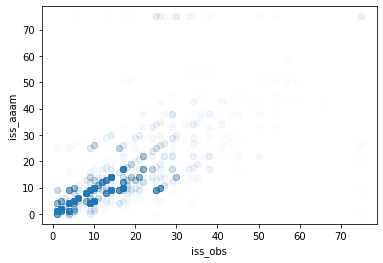

In [69]:
res.plot.scatter(x='iss_obs',y='iss_aaam', alpha=0.01, s=40)
#plt.xlim(1,45)
#plt.ylim(1,45)

<AxesSubplot:xlabel='iss_obs', ylabel='iss_icdpic'>

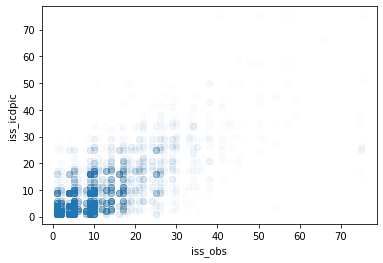

In [70]:
res.plot.scatter(x='iss_obs',y='iss_icdpic', alpha=0.01, s=40)
#plt.xlim(1,45)
#plt.ylim(1,45)

## Population injury rates

### Population ISS>=16 estimate

In [17]:
res.iss16_obs.mean()

0.1445

In [18]:
res.iss16_nmt.mean()

0.1247

In [19]:
res.iss16_aaam.mean()

0.0809

In [20]:
res.iss16_icdpic.mean()

0.1427

In [21]:
(0.1445-0.1247)/0.1445

0.1370242214532871

### Population MAIS>=3 estimate

In [22]:
res.mais3_obs.mean()

0.3296

In [23]:
res.mais3_nmt.mean()

0.299

In [24]:
res.mais3_aaam.mean()

0.38

In [25]:
res.mais3_icdpic.mean()

0.3162

### Population MAIS>=2 estimate

In [26]:
res.mais2_obs.mean()

0.6154

In [27]:
res.mais2_nmt.mean()

0.6102

In [28]:
res.mais2_aaam.mean()

0.8277

In [29]:
res.mais2_icdpic.mean()

0.5601

## Subpopulation analaysis

In [71]:
male_keys = demo[demo.SEX==1.0].inc_key.values

In [72]:
young_keys = demo[demo.AGEYEARS<18].inc_key.values
midage_keys = demo[(demo.AGEYEARS>=18) & (demo.AGEYEARS<65)].inc_key.values
old_keys = demo[demo.AGEYEARS>=65].inc_key.values

In [73]:
low_keys = res[res.iss16_obs==0].inc_key.values
high_keys = res[res.iss16_obs==1].inc_key.values

In [74]:
len(old_keys)

3184

### Males vs Females - accuracy ISS >=16

#### Males vs Females - NMT

In [75]:
calc_ci(res[res.inc_key.isin(male_keys)].iss16_correct_nmt.mean(), 10_000)

(0.9275137741046832, 0.9224316648251843, 0.932595883384182)

In [76]:
calc_ci(res[~res.inc_key.isin(male_keys)].iss16_correct_nmt.mean(), 10_000)

(0.9496660305343512, 0.9453808204938264, 0.9539512405748759)

#### Males vs Females - AAAM

In [77]:
calc_ci(res[res.inc_key.isin(male_keys)].iss16_correct_aaam.mean(), 10_000)

(0.9030647382920111, 0.8972656942465681, 0.908863782337454)

In [78]:
calc_ci(res[~res.inc_key.isin(male_keys)].iss16_correct_aaam.mean(), 10_000)

(0.9272423664122137, 0.9221514966431887, 0.9323332361812386)

#### Males vs Females - ICDPIC-R

In [79]:
calc_ci(res[res.inc_key.isin(male_keys)].iss16_correct_icdpic.mean(), 10_000)

(0.8605371900826446, 0.8537471850058146, 0.8673271951594747)

In [80]:
calc_ci(res[~res.inc_key.isin(male_keys)].iss16_correct_icdpic.mean(), 10_000)

(0.8907442748091603, 0.8846298628897558, 0.8968586867285648)

### Males vs Females - accuracy MAIS >= 3

#### Males vs Females - NMT

In [161]:
calc_ci(res[res.inc_key.isin(male_keys)].mais3_correct_nmt.mean(), 10_000)

(0.90616391184573, 0.9004485412017107, 0.9118792824897493)

In [162]:
calc_ci(res[~res.inc_key.isin(male_keys)].mais3_correct_nmt.mean(), 10_000)

(0.9215171755725191, 0.9162461502765165, 0.9267882008685218)

#### Males vs Females - AAAM

In [163]:
calc_ci(res[res.inc_key.isin(male_keys)].mais3_correct_aaam.mean(), 10_000)

(0.8300619834710744, 0.8227006480699591, 0.8374233188721897)

In [164]:
calc_ci(res[~res.inc_key.isin(male_keys)].mais3_correct_aaam.mean(), 10_000)

(0.8656965648854962, 0.8590133953397587, 0.8723797344312336)

#### Males vs Females - ICDPIC-R

In [165]:
calc_ci(res[res.inc_key.isin(male_keys)].mais3_correct_icdpic.mean(), 10_000)

(0.6967975206611571, 0.6877885381498742, 0.70580650317244)

In [166]:
calc_ci(res[~res.inc_key.isin(male_keys)].mais3_correct_icdpic.mean(), 10_000)

(0.6758110687022901, 0.6666368769540403, 0.68498526045054)

### Males vs Females - accuracy MAIS >= 2

#### Males vs Females - NMT

In [167]:
calc_ci(res[res.inc_key.isin(male_keys)].mais2_correct_nmt.mean(), 10_000)

(0.9545454545454546, 0.9504627961990394, 0.9586281128918698)

In [168]:
calc_ci(res[~res.inc_key.isin(male_keys)].mais2_correct_nmt.mean(), 10_000)

(0.958969465648855, 0.9550815928510508, 0.9628573384466592)

#### Males vs Females - AAAM

In [169]:
calc_ci(res[res.inc_key.isin(male_keys)].mais2_correct_aaam.mean(), 10_000)

(0.774965564738292, 0.7667805066870597, 0.7831506227895244)

In [170]:
calc_ci(res[~res.inc_key.isin(male_keys)].mais2_correct_aaam.mean(), 10_000)

(0.7108778625954199, 0.7019921095447139, 0.7197636156461258)

#### Males vs Females - ICDPIC-R

In [171]:
calc_ci(res[res.inc_key.isin(male_keys)].mais2_correct_icdpic.mean(), 10_000)

(0.7212465564738292, 0.7124581918299826, 0.7300349211176758)

In [172]:
calc_ci(res[~res.inc_key.isin(male_keys)].mais2_correct_icdpic.mean(), 10_000)

(0.75, 0.7415129510429125, 0.7584870489570875)

### Age - accuracy ISS >=16

####  NMT

In [86]:
calc_ci(res[res.inc_key.isin(young_keys)].iss16_correct_nmt.mean(), 10_000)

(0.9551543389633081, 0.9510978241821174, 0.9592108537444989)

In [87]:
calc_ci(res[res.inc_key.isin(midage_keys)].iss16_correct_nmt.mean(), 10_000)

(0.9393998823298686, 0.9347234133726522, 0.944076351287085)

In [88]:
calc_ci(res[res.inc_key.isin(old_keys)].iss16_correct_nmt.mean(), 10_000)

(0.9227386934673367, 0.9175053834645746, 0.9279720034700989)

#### AAAM

In [89]:
calc_ci(res[res.inc_key.isin(young_keys)].iss16_correct_aaam.mean(), 10_000)

(0.9330227140361095, 0.9281230539460501, 0.9379223741261689)

In [90]:
calc_ci(res[res.inc_key.isin(midage_keys)].iss16_correct_aaam.mean(), 10_000)

(0.9146891547362228, 0.9092140181385344, 0.9201642913339112)

In [91]:
calc_ci(res[res.inc_key.isin(old_keys)].iss16_correct_aaam.mean(), 10_000)

(0.9001256281407035, 0.8942489126556902, 0.9060023436257169)

#### ICDPIC-R

In [92]:
calc_ci(res[res.inc_key.isin(young_keys)].iss16_correct_icdpic.mean(), 10_000)

(0.9085614443797321, 0.9029121019281485, 0.9142107868313156)

In [93]:
calc_ci(res[res.inc_key.isin(midage_keys)].iss16_correct_icdpic.mean(), 10_000)

(0.8609531280643263, 0.8541716175864846, 0.867734638542168)

In [94]:
calc_ci(res[res.inc_key.isin(old_keys)].iss16_correct_icdpic.mean(), 10_000)

(0.8737437185929648, 0.8672338143309059, 0.8802536228550238)

### Age - accuracy MAIS >=3

####  NMT

In [173]:
calc_ci(res[res.inc_key.isin(young_keys)].mais3_correct_nmt.mean(), 10_000)

(0.9370995923121724, 0.9323410309277592, 0.9418581536965857)

In [174]:
calc_ci(res[res.inc_key.isin(midage_keys)].mais3_correct_nmt.mean(), 10_000)

(0.912924102765248, 0.9073979563533101, 0.918450249177186)

In [175]:
calc_ci(res[res.inc_key.isin(old_keys)].mais3_correct_nmt.mean(), 10_000)

(0.8988693467336684, 0.8929599144169563, 0.9047787790503804)

#### AAAM

In [176]:
calc_ci(res[res.inc_key.isin(young_keys)].mais3_correct_aaam.mean(), 10_000)

(0.8666278392545137, 0.8599642996547149, 0.8732913788543125)

In [177]:
calc_ci(res[res.inc_key.isin(midage_keys)].mais3_correct_aaam.mean(), 10_000)

(0.8376152186703275, 0.8303866715979775, 0.8448437657426775)

In [178]:
calc_ci(res[res.inc_key.isin(old_keys)].mais3_correct_aaam.mean(), 10_000)

(0.8451633165829145, 0.8380730376489369, 0.8522535955168922)

#### ICDPIC-R

In [179]:
calc_ci(res[res.inc_key.isin(young_keys)].mais3_correct_icdpic.mean(), 10_000)

(0.7198602213162493, 0.7110585012945105, 0.728661941337988)

In [180]:
calc_ci(res[res.inc_key.isin(midage_keys)].mais3_correct_icdpic.mean(), 10_000)

(0.7156305157874093, 0.7067886892153243, 0.7244723423594943)

In [181]:
calc_ci(res[res.inc_key.isin(old_keys)].mais3_correct_icdpic.mean(), 10_000)

(0.6265703517587939, 0.6170895429284915, 0.6360511605890964)

### Age - accuracy MAIS >=2

####  NMT

In [182]:
calc_ci(res[res.inc_key.isin(young_keys)].mais2_correct_nmt.mean(), 10_000)

(0.9644729178800233, 0.9608448044210919, 0.9681010313389548)

In [183]:
calc_ci(res[res.inc_key.isin(midage_keys)].mais2_correct_nmt.mean(), 10_000)

(0.9501863110413806, 0.9459221381156632, 0.9544504839670981)

In [184]:
calc_ci(res[res.inc_key.isin(old_keys)].mais2_correct_nmt.mean(), 10_000)

(0.9619974874371859, 0.958249922250759, 0.9657450526236129)

#### AAAM

In [185]:
calc_ci(res[res.inc_key.isin(young_keys)].mais2_correct_aaam.mean(), 10_000)

(0.6907396622015143, 0.6816807639602218, 0.6997985604428067)

In [186]:
calc_ci(res[res.inc_key.isin(midage_keys)].mais2_correct_aaam.mean(), 10_000)

(0.7448519317513238, 0.7363074212499657, 0.7533964422526819)

In [187]:
calc_ci(res[res.inc_key.isin(old_keys)].mais2_correct_aaam.mean(), 10_000)

(0.7842336683417085, 0.7761711511814542, 0.7922961855019628)

#### ICDPIC-R

In [188]:
calc_ci(res[res.inc_key.isin(young_keys)].mais2_correct_icdpic.mean(), 10_000)

(0.7291788002329644, 0.7204688751987558, 0.7378887252671731)

In [189]:
calc_ci(res[res.inc_key.isin(midage_keys)].mais2_correct_icdpic.mean(), 10_000)

(0.7015101000196117, 0.6925412274064385, 0.7104789726327848)

In [190]:
calc_ci(res[res.inc_key.isin(old_keys)].mais2_correct_icdpic.mean(), 10_000)

(0.7864321608040201, 0.7783995887324168, 0.7944647328756235)